# Management Analysis Report

DAT5303 - Machine Learning

By: Vi Nguyen

The analysis of Apprentice Chef cooking service was done to predict revenue, as well as the key factors that lead to the successes of "Halfway There", the cross selling promotion. 

# Revenue Insights

We can see that customers who are more engaged with the Apprentice Chef services, greatly impacted revenue generation based on chart 5.1.1 below.

Key actionable insights from revenue based on highly correlated variables are for Apprentice Chef to recommend new dishes suited to customers previous orders and based on their median meal ratings in order to diversify their offerings. This can be done through the master classes the program as to offer, in order to see how likely a consumer diversifies, as well as keeping the consumer engaged with Apprentice Chef.  

OLS Model R2 = 0.773	

# Halfway There Insights

The success of the promotion was highly dependent on which email domain was used. Customers who used junk or personal emails were more likely to subscribe to the promotion. As well as the number of names a customer used based on chart 5.2.1 of feature importance.

Apprentice Chef should focus on gathering information and understanding the consumer through psychographic and demographic needs. Since the important insights about a consumers’ reason for purchase is based on email domains and number of names and not many other factors.

Pruned Tree Model AUC: 0.732


# Concluding Actions

Revenue be increased by funneling more customers through the key factors that promotes revenue generation, as well as improving other highly correlated variables to revenue, such as improving the master class program.
Much of Apprentice Chef's promotional success depended not on what we understood about the consumer, but more so based on the kind of information they inputted. This would prevent the company from further understanding their customers and impede on promotional success. 

# Models

In [37]:
# importing all libraries
import pandas as pd                                   # data science essentials
import matplotlib.pyplot as plt                       # data visualization
import seaborn as sns                                 # enhanced data visualization
import numpy as np                                    # numpy for math
from sklearn.model_selection import train_test_split  # train-test split
from sklearn.linear_model import LinearRegression   # logistic regression
import statsmodels.formula.api as smf                 # logistic regression
from sklearn.metrics import confusion_matrix          # confusion matrix
from sklearn.metrics import roc_auc_score             # auc score

# CART model packages
from sklearn.tree import DecisionTreeClassifier       # classification trees
from sklearn.tree import export_graphviz              # exports graphics
from six import StringIO                              # saves objects in memory
from IPython.display import Image                     # displays on frontend
import pydotplus                                      # interprets dot objects

#Packages for Classification Tree Modelling
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.metrics import make_scorer                 # customizable scorer

# setting pd print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# specify path and file name
file  = 'Chef_Ft_Regression.xlsx'
file2 = 'Chef_Ft_Classification.xlsx'


# reading the file

#regression file
chefr = pd.read_excel(io = file)
#classification file
chefc = pd.read_excel(io = file2)

In [38]:
## setting up data for OLS Regression ##


# preparing explanatory variable data
chefr_data  = chefr.drop(['REVENUE','log_REVENUE',
                          'NAME', 'EMAIL','FIRST_NAME',
                          'CLEAN_MAIL','FAMILY_NAME'],
                           axis = 1)


# preparing response variable data
# depending on what one we want to use
chefr_target = chefr.loc[ : , 'REVENUE']
log_chefr_target = chefr.loc[ : , 'log_REVENUE'] 


# preparing training and testing sets (all letters are lowercase)
# using the log revenue as our target instead

x_train, x_test, y_train, y_test = train_test_split(
            chefr_data,
            log_chefr_target,
            test_size    = 0.25,
            random_state = 219)

## OLS Regression Model

In [39]:
# applying OLS model in scikit-learn

# preparing response variable
log_chefr_target = chefr['log_REVENUE']

###############################################
## setting up full data for train-test split ##
###############################################

# FULL X-dataset (normal Y)
x_train_FULL, x_test_FULL, y_train_FULL, y_test_FULL = train_test_split(
            chefr_data,     # x-variables
            log_chefr_target,   # y-variable
            test_size = 0.25,
            random_state = 219)

In [12]:
###############################################
##        OLS MODEL WITH FULL DATA           ##
###############################################

# INSTANTIATING a model object
lr = LinearRegression()

# Fit to training data
lr_fit = lr.fit(x_train_FULL, y_train_FULL)

#predicting new data
lr_pred = lr_fit.predict(x_test_FULL)


#Results print out
print('OLS Training Score :', lr.score(x_train_FULL, y_train_FULL).round(4))  # using R-square
print('OLS Testing Score  :',  lr.score(x_test_FULL, y_test_FULL).round(4)) # using R-square

#creating values
lr_train_score = lr.score(x_train_FULL, y_train_FULL).round(4)
lr_test_score = lr.score(x_test_FULL, y_test_FULL).round(4)


# displaying and saving the gap between training and testing
print('OLS Train-Test Gap :', abs(lr_train_score - lr_test_score).round(4))
lr_test_gap = abs(lr_train_score - lr_test_score).round(4)

OLS Training Score : 0.7825
OLS Testing Score  : 0.7731
OLS Train-Test Gap : 0.0094


### Feature Correlations with Revenue Prediction

Text(0.5, 1.0, 'Most Correlated Features Matrix')

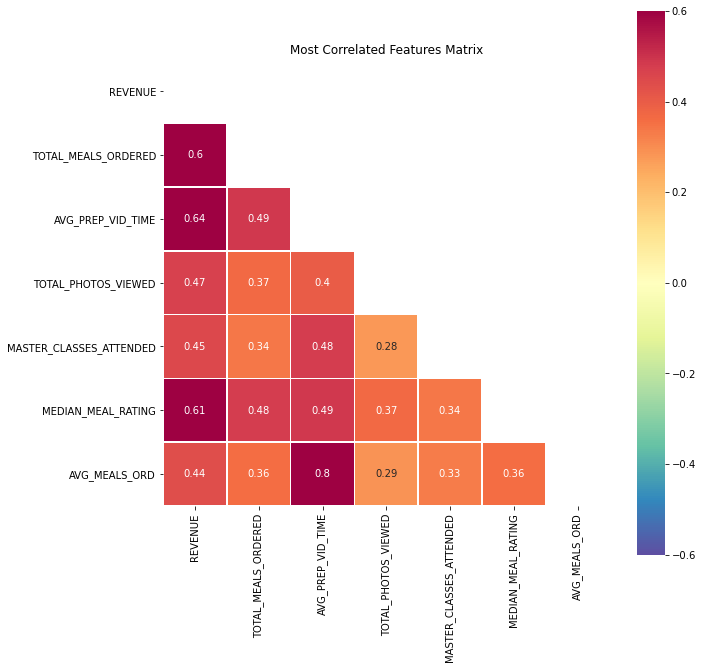

In [64]:
#creating correlation matrix
chefr_corr  = chefr.corr().round(2)

#subset correlation matrix
chefr_corr2 = chefr_corr.loc[ ['REVENUE','TOTAL_MEALS_ORDERED',
                              'AVG_PREP_VID_TIME','TOTAL_PHOTOS_VIEWED','MASTER_CLASSES_ATTENDED',
                              'MEDIAN_MEAL_RATING','AVG_MEALS_ORD'],
                             ['REVENUE','TOTAL_MEALS_ORDERED',
                              'AVG_PREP_VID_TIME','TOTAL_PHOTOS_VIEWED','MASTER_CLASSES_ATTENDED',
                              'MEDIAN_MEAL_RATING','AVG_MEALS_ORD'] ]

#plotting matrix
fig, ax = plt.subplots(figsize = (10, 10))

#correlation matrix from subset
mask    = np.zeros_like(chefr_corr2)

mask[np.triu_indices_from(mask)] = True
sns.heatmap(chefr_corr2, 
            cmap        = 'Spectral_r', 
            mask        = mask, 
            square      = True,
            annot       = True, 
            vmin        = -0.6, 
            vmax        = 0.6, 
            linewidths  = 0.5)

plt.title('Most Correlated Features Matrix')

## Pruned Tree Classification Model 

In [41]:
#dropping categorical variables/variables with strings

# declaring x-variables
chefc_data = chefc.drop(['CROSS_SELL_SUCCESS', 'NAME', 'EMAIL',
                       'FIRST_NAME', 'FAMILY_NAME', 'CLEAN_MAIL'], axis = 1)

In [42]:
# creating a variable dictionary to store candidate models

variable_dict = {

 # significant variables only (set 2)
 'logit_sig_2'  : ['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 
                  'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'EARLY_DELIVERIES',
                  'REFRIGERATED_LOCKER', 'junk', 'work', 
                  'NUM_OF_NAMES'],
}

In [43]:
#Initiating data in the pruned tree model
chefc_data   =  chefc.loc[ : , variable_dict['logit_sig_2']]
chefc_target =  chefc.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                    chefc_data,
                    chefc_target,
                    random_state = 219,
                    test_size    = 0.25,
                    stratify     = chefc_target)

In [44]:
# Running Pruned Tree Model
pruned_tree = DecisionTreeClassifier(max_depth        = 3,
                                     min_samples_leaf = 25,
                                     random_state     = 219)

# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.7402
Testing  ACCURACY: 0.7762
AUC Score        : 0.732


In [45]:
#creating variables from confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()

In [46]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

### Pruned Tree Plot Features

<ipython-input-46-8914a6291de9>:22: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


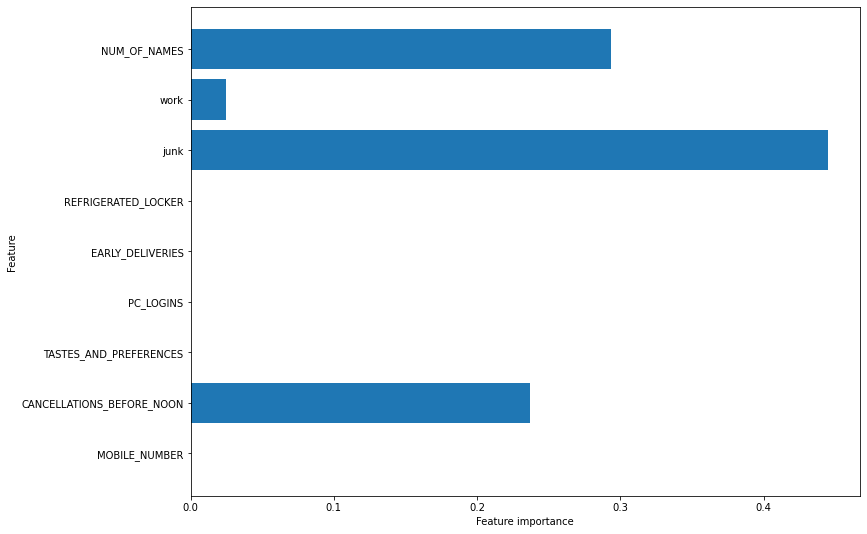

In [47]:
# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train  = x_train,
                         export = False)

In [65]:
# MODEL RESULTS
print(f"""
Model           R-Squared     AUC Score      TN, FP, FN, TP
-----            --------     ---------      --------------
OLS Full Data    {lr_train_score}          NA                NA
Pruned Tree        NA          {pruned_tree_auc_score}        {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}

""")


Model           R-Squared     AUC Score      TN, FP, FN, TP
-----            --------     ---------      --------------
OLS Full Data    0.7825          NA                NA
Pruned Tree        NA          0.732        (95, 61, 48, 283)


